In [1]:
!python -m pip install git+https://github.com/VissaMoutafis/opacus.git@35b88529db696444a87d166ca429232d46495658

  Cloning https://github.com/VissaMoutafis/opacus.git (to revision 35b88529db696444a87d166ca429232d46495658) to /tmp/pip-req-build-dbqlglkx
  Running command git clone -q https://github.com/VissaMoutafis/opacus.git /tmp/pip-req-build-dbqlglkx
  Running command git rev-parse -q --verify 'sha^35b88529db696444a87d166ca429232d46495658'
  Running command git fetch -q https://github.com/VissaMoutafis/opacus.git 35b88529db696444a87d166ca429232d46495658


In [2]:
!pip install hiplot 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, datasets
from tqdm.notebook import tqdm

!cp ../input/mia-v2 mia_v2 -r
from mia_v2.torch2tf import *
from mia_v2.attack_model import *
from mia_v2.label_only import *
from mia_v2.shadow_models import *
from mia_v2.utilities import *
from mia_v2.wrappers import ConfidenceVectorAttack, LabelOnlyAttack

from opacus import PrivacyEngine

from math import log, inf

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import warnings
warnings.simplefilter("ignore")

cp: cannot stat '../input/mia-v2': No such file or directory
cuda:0


In [4]:
ATTACKER_DATASET_SIZES = [10000, 20000]
SHADOW_MODELS = [1, 10, 20]
SHADOW_DATASET_SIZE = 7500
TARGET_DATASET_SIZES = [5000, 7500, 10000]
EPSILON_PER_STEP = [log(20), log(15), log(10), log(5)]
MAX_GRAD_NORMS = [1, 1.2, 2, 5.3, 8.5]
EPOCHS = 100
SAMPLE_TRAINS = 10
TEST_SET_SIZE = 0.3

prec = []
rec = []
auc = []
model_vuln = [] # model vulnerability metric
model_acc = [] # accuracy gap between undefended and defended model 

In [5]:
class TargetModel(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 32, 3)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(32, 64, 3)
      self.fc1 = nn.Linear(2304, 256)
      self.fc2 = nn.Linear(256, 10)
      self.double()
      self.to(device)


    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [6]:
def f_shadow():
  return TfIgniter((3, 32, 32), (32, 32, 3), TargetModel(), device)

In [12]:
def create_target_model(train_images, train_labels, test_images, test_labels, epochs, privacy=None):
    target_model = TargetModel()
    criterion = nn.CrossEntropyLoss
    optimizer = {'builder':optim.Adam, 'args':{'lr':0.001}}
    igniter = TfIgniter((3, 32, 32), (32, 32, 3), target_model, device)
    if privacy is not None:
      igniter.fit(train_images, 
                  train_labels, 
                  validation_data=(test_images, test_labels), 
                  verbose=True, 
                  privacy=privacy, 
                  epochs=epochs, 
                  batch_size =32, 
                  es=CustomEarlyStopping(patience=10, min_delta=2e-5), optimizer=optimizer, criterion=criterion)
    else:
      igniter.fit(train_images, 
                  train_labels, 
                  validation_data=(test_images, test_labels), 
                  verbose=True, 
                  epochs=epochs, 
                  batch_size =32, 
                  es=CustomEarlyStopping(patience=10, min_delta=2e-5), optimizer=optimizer, criterion=criterion)
    return igniter

In [18]:
def perform_attack(attack, target_model, train_images, train_labels, test_images, test_labels, configs):
    attack.target_model = target_model
    attack.target_dataset = (train_images, train_labels)
    score_ = attack.evaluate_attack()
    auc.append({**configs, 'AUC Score' : score_[1]
      })
    rec.append({**configs, 'Recall' : score_[0]['macro avg']['recall']
      })
    prec.append({**configs, 'Precision' : score_[0]['macro avg']['precision']
      })
    model_vuln.append({**configs, 'Model Vulnerability' : evaluate_model_vulnerability(target_model, (train_images, train_labels), (test_images, test_images), 'tf', batch_size=256)
      })
    
    y_pred = np.argmax(target_model.predict(test_images), axis=1)
    acc = accuracy_score(test_labels, y_pred)
    model_acc.append({**config, 'Classification Accuracy': acc})    
    

In [17]:
def dp_study(images, labels): 
    config = {}
    for d_attacker_size in ATTACKER_DATASET_SIZES:
        config['D_attacker'] = d_attacker_size
        attacker_images, attacker_labels = images[:d_attacker_size], labels[:d_attacker_size]
        for n_shadow_models in SHADOW_MODELS:
            config['N_Shadows'] = n_shadow_models
            attacker_dataset = (attacker_images.reshape(-1, 32, 32, 3), attacker_labels)
            attack = ConfidenceVectorAttack(None, attacker_dataset, attacker_dataset, 
                                            shadow_creator=f_shadow, 
                                            attack_model_creator=cifar_10_f_attack_builder,
                                            n_shadows=n_shadow_models, 
                                            D_shadow_size=SHADOW_DATASET_SIZE, 
                                            verbose=False)
            es = CustomEarlyStopping(patience=15, min_delta=2e-5)
            criterion = nn.CrossEntropyLoss
            optimizer = {'builder':optim.Adam, 'args':{'lr':0.003}}
            attack.perform_attack(shadow={'epochs':100, 'batch_size':32, 'es':es, 'optimizer':optimizer, 'criterion':criterion})
            
            for d_target_size in TARGET_DATASET_SIZES:
                config['D_target'] = d_target_size
                config['eps'] = None
                config['max_grad_norm'] = None
                # add the test set in the total dataset size
                d_size = int(d_target_size//(TEST_SET_SIZE)+1)
                assert d_size+d_attacker_size <= len(images) # sanity check 
                # make sure that attacker and target dataset are disjoint
                train_images, train_labels = images[d_attacker_size:d_attacker_size+d_size], labels[d_attacker_size:d_attacker_size+d_size]
                
                # TRAIN & ATTACK UNDEFENDED MODEL
                train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=TEST_SET_SIZE, shuffle=True, random_state=0)
                target_model = create_target_model(train_images, train_labels, test_images, test_labels, EPOCHS)
                
                perform_attack(attack, target_model, train_images, train_labels, attacker_images, attacker_labels, config)
                # TRAIN & ATTACK DEFENDED MODELS
                for eps in EPSILON_PER_STEP:
                    config['eps'] = eps
                    for max_grad_norm in MAX_GRAD_NORMS:
                        config['max_grad_norm'] = max_grad_norm
                        # set up privacy details
                        total_epsilon = EPOCHS*eps
                        delta = 1/d_target_size
                        privacy = {
                            'engine':PrivacyEngine(),
                            'args':{
                                'epochs': EPOCHS,
                                'target_epsilon':total_epsilon,
                                'target_delta': delta,
                                'max_grad_norm':max_grad_norm
                            }
                        }
                        for sample_train_id in range(SAMPLE_TRAINS):
                            target_model = create_target_model(train_images, train_labels, EPOCHS, privacy)
                            perform_attack(attack, target_model, train_images, train_labels, attacker_images, attacker_labels, config)
                            


In [15]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
images = np.concatenate((train_images, test_images))
labels = np.concatenate((train_labels, test_labels)).reshape(-1).astype(np.int64)
images = (images / 255).reshape((-1, 3, 32, 32))

  0%|          | 0/100 [00:00<?, ?it/s]

Preparing shadow batch of size 4950
Done!


  0%|          | 0/100 [00:00<?, ?it/s]

class-1 acc: 0.6488625407218933
class-2 acc: 0.6934598088264465
class-3 acc: 0.7043090462684631
class-4 acc: 0.5628091096878052
class-5 acc: 0.6336734890937805
class-6 acc: 0.363209992647171
class-7 acc: 0.6086528897285461
class-8 acc: 0.6292585134506226
class-9 acc: 0.6555282473564148
class-10 acc: 0.5723618268966675
              precision    recall  f1-score   support

         Out       0.62      0.57      0.59     10000
          In       0.60      0.64      0.62     10000

    accuracy                           0.61     20000
   macro avg       0.61      0.61      0.61     20000
weighted avg       0.61      0.61      0.61     20000

AUC: 0.6560535000000001


AttributeError: ignored

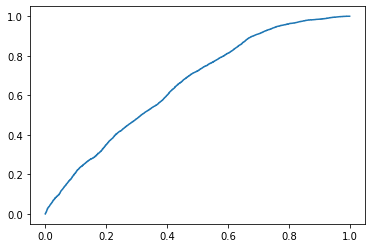

In [19]:
dp_study(images, labels)

In [ ]:
attack.target_model = igniter
_score = attack.evaluate_attack()